In [1]:
import collections
import itertools
import json

import matplotlib.pyplot as plt
import more_itertools
import numpy as np
import redis
import tqdm

# Store patent data in Redis

In [2]:
r_patent_to_codes = redis.Redis(host="127.0.0.1", port=6379, db=0, decode_responses=True)
r_dates_to_patents = redis.Redis(host="127.0.0.1", port=6379, db=1, decode_responses=True)

In [3]:
def store_patent_data_in_redis(r_patent_to_codes, r_dates_to_patents):
    """
    #0000003 - 473119000 - X - 18360811
    #0000004 - 142010000 - O - 18360810
    """
    rp_patent_to_codes = r_patent_to_codes.pipeline()
    rp_dates_to_patents = r_dates_to_patents.pipeline()
    line_cnt = 0
    with open("data/mcfpat1402-with_issue_date.txt") as handle:
        for chunk in tqdm.tqdm(more_itertools.chunked(handle, 10_000)):
            for line in chunk:
                line_cnt += 1
                patent_number = line[:7]
                classification = line[7:10]

                subclassification = line[10:16]
                classification_type_code = line[16]
                issue_date = line[17:25]

                rp_patent_to_codes.sadd(patent_number, classification + subclassification)
                rp_dates_to_patents.sadd(issue_date, patent_number)

            rp_patent_to_codes.execute()
            rp_dates_to_patents.execute()        
    print(f"Lines added: {line_cnt}")

In [6]:
# store_patent_data_in_redis(r_patent_to_codes, r_dates_to_patents)

3211it [21:33,  2.48it/s]

Lines added: 32101924


In [4]:
patent_numbers = sorted(r_patent_to_codes.keys())
issue_dates = sorted(r_dates_to_patents.keys())

# calculate the code per patent distro
# code_counts = []
# for pn in tqdm.tqdm(patent_numbers):
#     code_counts.append(len(r_patent_to_codes.smembers(pn)))

import json
with open("results/patent_code_counts.json") as handle:
    code_counts = json.load(handle)

In [10]:
import json
# with open("patent_novelties.json", 'w') as handle:
#     json.dump({
#         "novelty_count": novelty_count,
#         "novelty_pair_count": novelty_pair_count,
#     }, handle)
with open("results/patent_novelties.json") as handle:
    temp = json.load(handle)
    novelty_count = temp["novelty_count"]
    novelty_pair_count = temp["novelty_pair_count"]

Text(0.5, 1.0, 'Novelties in Patents')

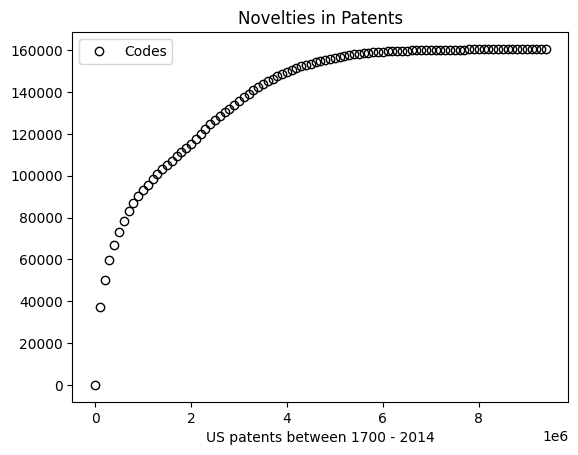

In [43]:
STEP_SIZE = 100_000

plt.plot(
    range(0, len(novelty_count), STEP_SIZE),
    novelty_count[::STEP_SIZE],
    "o", color="black", markerfacecolor='none',
    label="Codes",
)
plt.xlabel("US patents between 1700 - 2014")
plt.legend()
plt.title("Novelties in Patents")

Text(0.5, 1.0, 'Pair novelties in Patents (linear scale)')

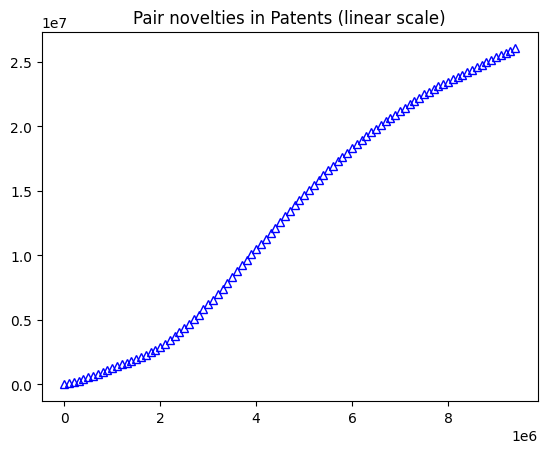

In [16]:
STEP_SIZE = 100_000

plt.plot(
    range(0, len(novelty_pair_count), STEP_SIZE),
    novelty_pair_count[::STEP_SIZE],
    "^", color="blue", markerfacecolor='none',
    label="Codes",
)
plt.title("Pair novelties in Patents (linear scale)")

Text(0.5, 1.0, 'Combinatorial Growth (2-element-combinations)')

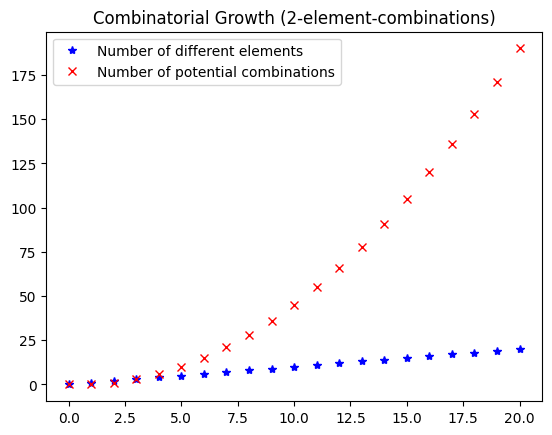

In [22]:

nums = list(range(21))
plt.plot(nums, nums, "b*", label="Number of different elements")
plt.plot([n * (n-1) / 2 for n in nums], "rx", label="Number of potential combinations")
plt.legend()
plt.title("Combinatorial Growth (2-element-combinations)")

Text(0.5, 1.0, 'Sublinear Combinatorial Growth (2-element-combinations)')

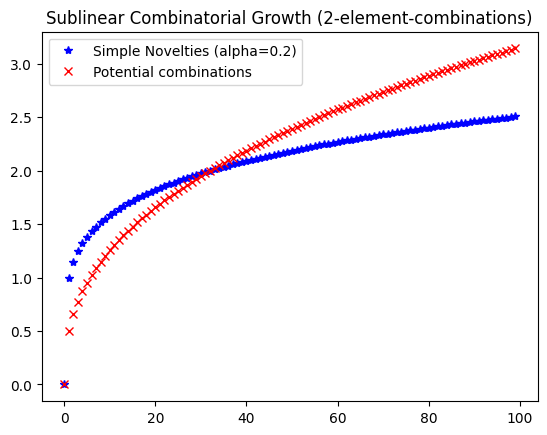

In [65]:
nums = list(range(100))
c,  alpha = 1.0, 0.2
plt.plot(nums, [c* x**alpha for x in nums], "b*", label=f"Simple Novelties (alpha={alpha})")
plt.plot([c/2*x**(2*alpha) for x in nums], "rx", label="Potential combinations")
plt.legend()
plt.title("Sublinear Combinatorial Growth (2-element-combinations)")

Generate the fake data alongside with the true patents:

Text(0.5, 1.0, 'Novelties in Patents')

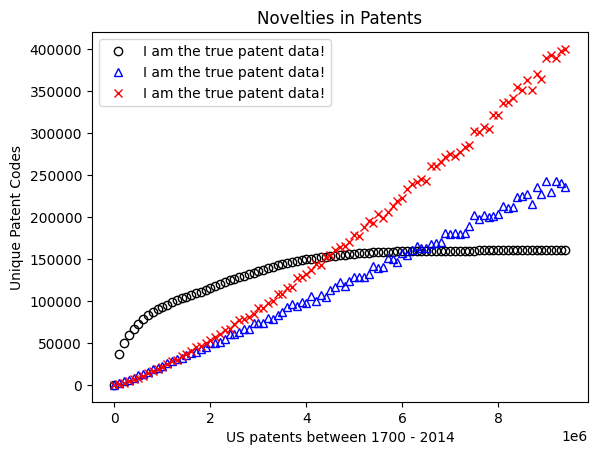

In [63]:
import random

STEP_SIZE = 100_000

xs = list(range(0, len(novelty_count), STEP_SIZE))
plt.plot(
    xs,
    novelty_count[::STEP_SIZE],
    "o", color="black", markerfacecolor='none',
    label="I am the true patent data!",
)
plt.plot(
    xs,
    [x**1.05 * (1 + random.random() / 10) / 90     for x in xs],
    "^", color="blue", markerfacecolor='none',
    label="I am the true patent data!",
)
plt.plot(
    xs,
    [x**1.3 * (1 + random.random() / 15) / 3000     for x in xs],
    "x", color="red", markerfacecolor='none',
    label="I am the true patent data!",
)
plt.xlabel("US patents between 1700 - 2014")
plt.ylabel("Unique Patent Codes")
plt.legend()
plt.title("Novelties in Patents")

In [27]:
issue_dates[1], issue_dates[-1]

('17000101', '20140225')

In [72]:
r_dates_to_patents.smembers(issue_dates[1])
r_patent_to_codes.smembers('X004871')

{'122178000'}

In [6]:
cc = collections.Counter(code_counts)

[]

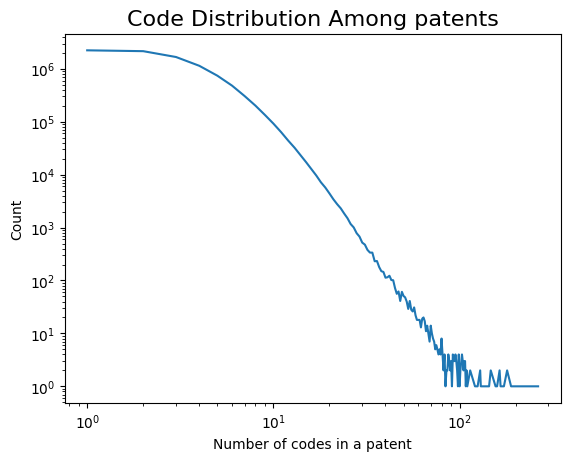

In [12]:
plt.plot(sorted(cc.keys()), [cc[k] for k in sorted(cc.keys())])
plt.title("Code Distribution Among patents", fontsize=16)
plt.xlabel("Number of codes in a patent")
plt.ylabel("Count")
plt.loglog()